## Accessing Sentinel-1 RTC data with the Planetary Computer STAC API

The [Sentinel 1 RTC](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) product in this collection is a radiometrically terrain corrected product derived from the [Sentinel-1 Ground Range Detected (GRD)](https://planetarycomputer.microsoft.com/dataset/sentinel-1-grd) Level-1 products produced by the European Space Agency.

### Environment setup

Running this notebook requires an API key.

* The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.
* To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `planetary_computer.settings.set_subscription_key(<YOUR API Key>)`

See [when an account is needed](https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed) for more, and [request an account](http://planetarycomputer.microsoft.com/account/request) if needed.




### TODO
- [x] group by solar day
- [ ] dont load data no 90% clear - might be a problem, keep investigating
- [ ] why is distribution not bimodel - not too fussed at the moment
- [x] make sum of time series
- [x] make count of time series
- [x] make frequency of time series
- [x] export as geotiff


Notebook taken from here
https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Radar_water_detection/

In [1]:
import ipyleaflet
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pystac
import pystac_client
import planetary_computer
import requests
import rich.table

import odc.stac
from datacube.utils.cog import write_cog

from scipy.ndimage import uniform_filter
from scipy.ndimage import variance

from IPython.display import Image

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Choose an area and time of interest

We'll search for assets acquired over Panama in the first week of May, 2022. You can use the [Planetary Computer Explorer](https://planetarycomputer.microsoft.com/explore?c=-79.6735%2C9.0461&z=9.91&ae=0&v=2&d=sentinel-1-rtc&s=false%3A%3A100%3A%3Atrue&m=Most+recent+-+VV%2C+VH&r=VV%2C+VH+False-color+composite) to find areas of interest.

In [3]:
site_name = 'eden'
time = "2020-02-07/2020-02-28"
bbox = [149.5, -37.2, 150.1, -36.9] # eden

# site_name = 'dea_example'
# time = "2017-01-01/2017-03-31"
# bbox = [130.324, -11.288, 130.453, -11.086] # dea example

starttime, endtime = time.split('/')
search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=bbox, datetime=time # eden
    # collections=["sentinel-1-rtc"], bbox=bbox, datetime=time # dea example
)
items = search.item_collection()
print(f"Found {len(items)} items")
item = items[0]

Found 3 items


In [4]:
%%time
# load as odc stac dataset
ds_s1 = odc.stac.load(items,
                        bbox=bbox,
                        crs="EPSG:3577",
                        resolution=10,
                        groupby='solar_day')

CPU times: user 16.6 s, sys: 6.75 s, total: 23.3 s
Wall time: 36.1 s


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


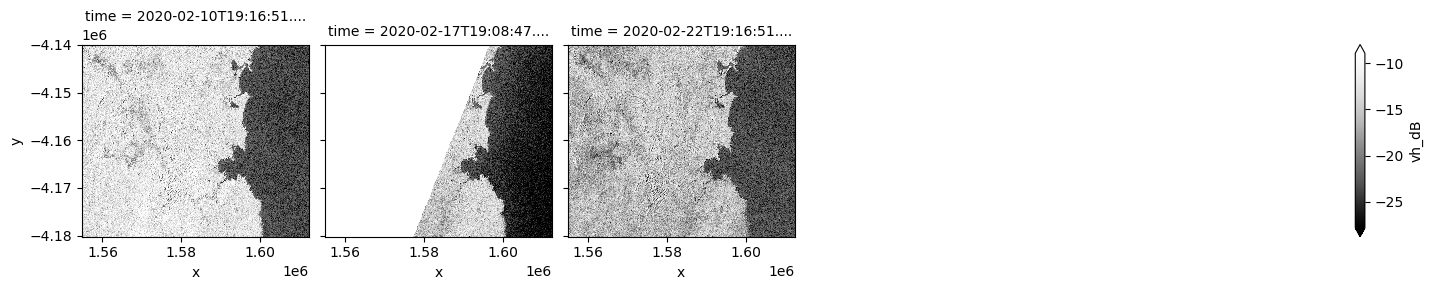

In [5]:
# Scale to plot data in decibels
ds_s1["vh_dB"] = 10 * np.log10(ds_s1.vh)

# Plot all VH observations for the year
ds_s1.vh_dB.plot(cmap="Greys_r", robust=True, col="time", col_wrap=5)
plt.show()

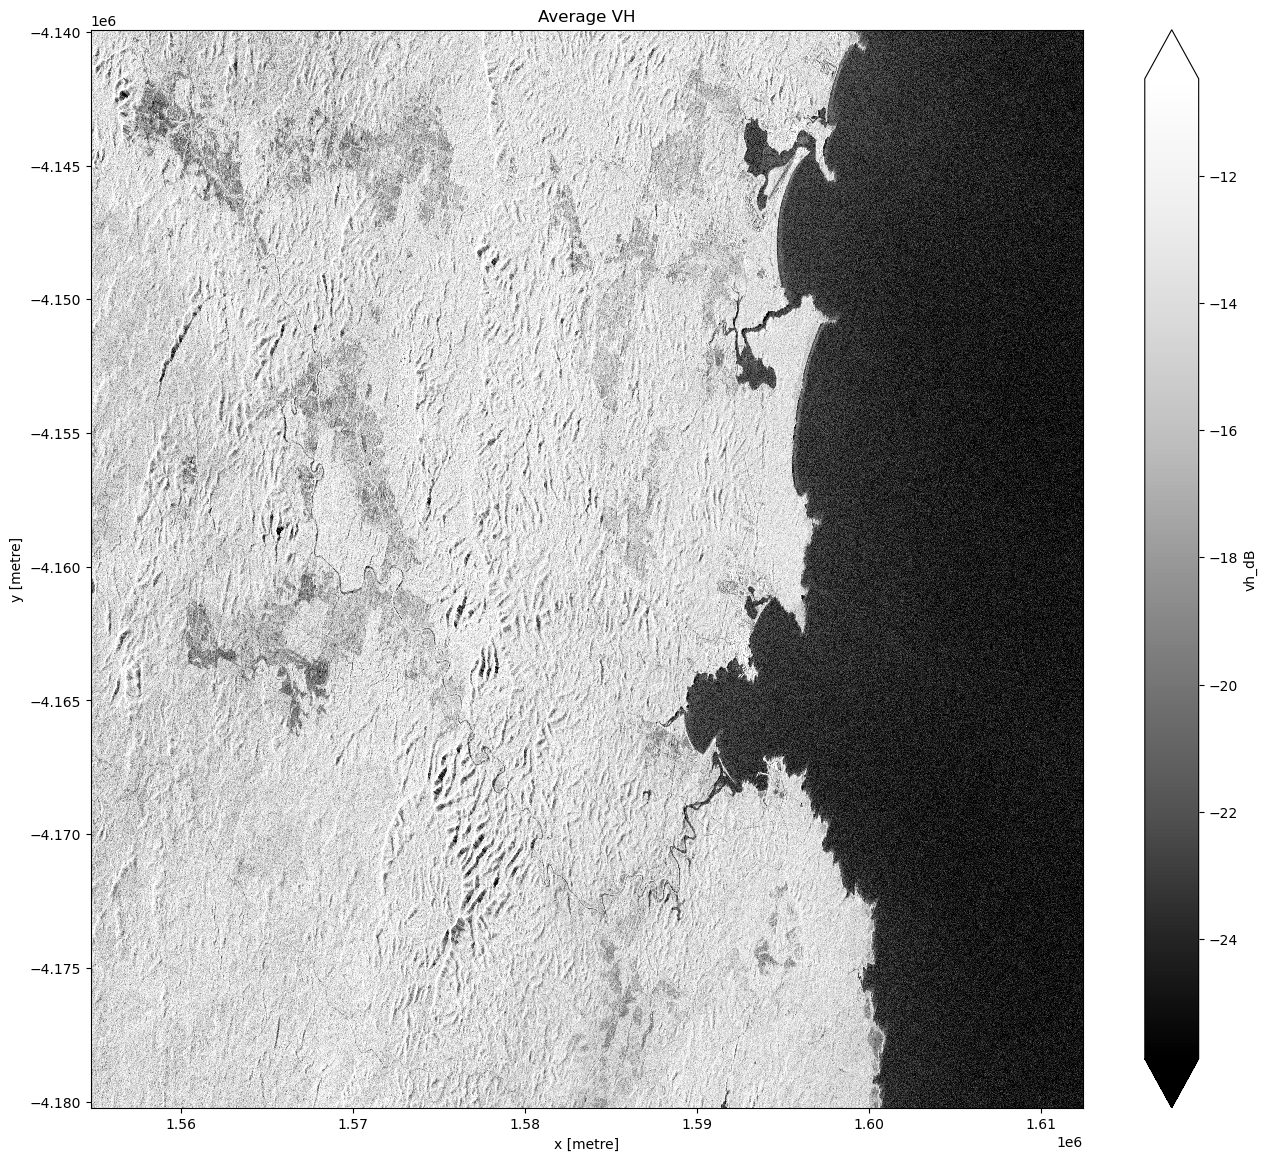

In [33]:
# Plot the average of all VH observations
mean_vh_dB = ds_s1.vh_dB.mean(dim="time")

fig = plt.figure(figsize=(6, 4))
mean_vh_dB.plot(cmap="Greys_r", robust=True)
plt.title("Average VH")
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


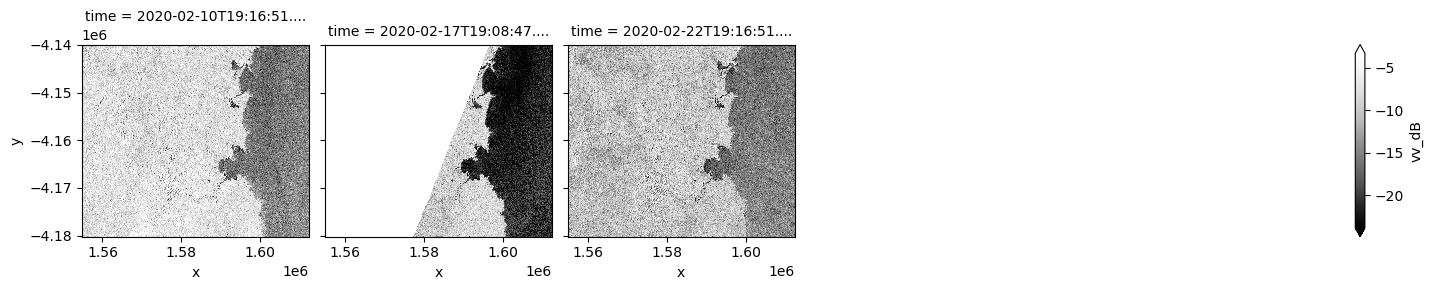

In [7]:
# Scale to plot data in decibels
ds_s1["vv_dB"] = 10 * np.log10(ds_s1.vv)

# Plot all VV observations for the year
ds_s1.vv_dB.plot(cmap="Greys_r", robust=True, col="time", col_wrap=5)
plt.show()

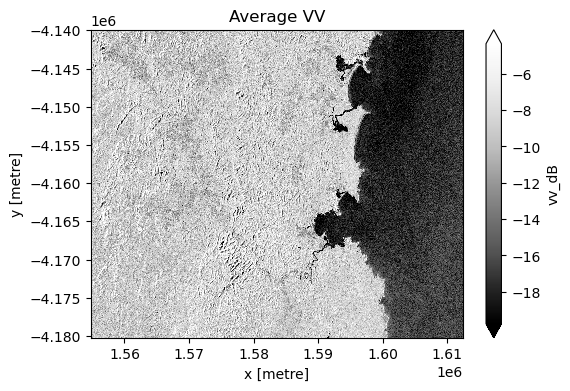

In [8]:
# Plot the average of all VV observations
mean_vv_dB = ds_s1.vv_dB.mean(dim="time")

fig = plt.figure(figsize=(6, 4))
mean_vv_dB.plot(cmap="Greys_r", robust=True)
plt.title("Average VV")
plt.show()

In [9]:
# Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [10]:
# Set any null values to 0 before applying the filter to prevent issues
ds_s1_filled = ds_s1.where(~ds_s1.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
ds_s1["filtered_vv"] = ds_s1_filled.vv.groupby("time").apply(lee_filter, size=7)
ds_s1["filtered_vh"] = ds_s1_filled.vh.groupby("time").apply(lee_filter, size=7)

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


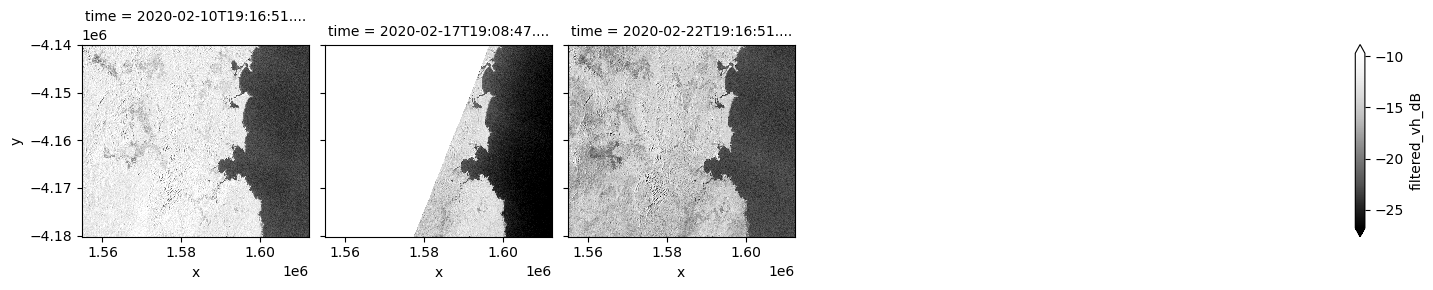

In [11]:
# Scale to plot data in decibels
ds_s1["filtered_vh_dB"] = 10 * np.log10(ds_s1.filtered_vh)

# Plot all filtered VH observations for the year
ds_s1.filtered_vh_dB.plot(cmap="Greys_r", robust=True, col="time", col_wrap=5)
plt.show()

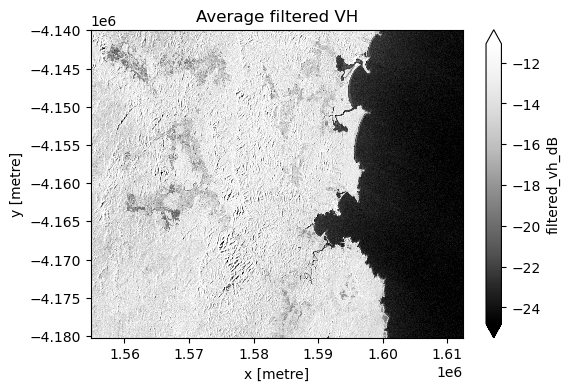

In [12]:
# Plot the average of all filtered VH observations
mean_filtered_vh_dB = ds_s1.filtered_vh_dB.mean(dim="time")

fig = plt.figure(figsize=(6, 4))
mean_filtered_vh_dB.plot(cmap="Greys_r", robust=True)
plt.title("Average filtered VH")
plt.show()

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


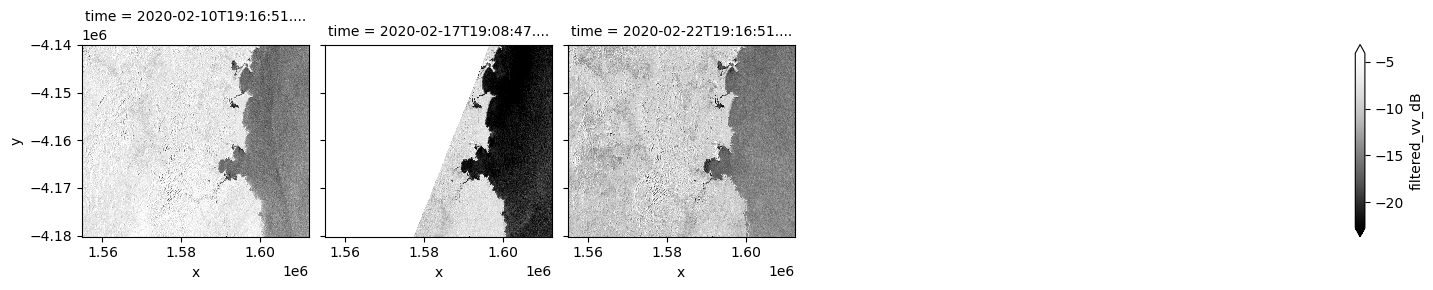

In [13]:
# Scale to plot data in decibels
ds_s1["filtered_vv_dB"] = 10 * np.log10(ds_s1.filtered_vv)

# Plot all filtered VV observations for the year
ds_s1.filtered_vv_dB.plot(cmap="Greys_r", robust=True, col="time", col_wrap=5)
plt.show()

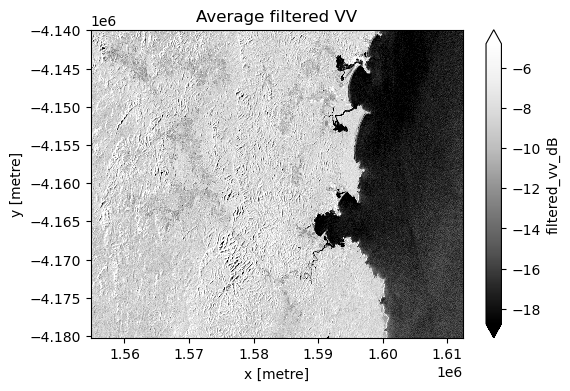

In [14]:
# Plot the average of all filtered VV observations
mean_filtered_vv_dB = ds_s1.filtered_vv_dB.mean(dim="time")

fig = plt.figure(figsize=(6, 4))
mean_filtered_vv_dB.plot(cmap="Greys_r", robust=True)
plt.title("Average filtered VV")
plt.show()

## VH

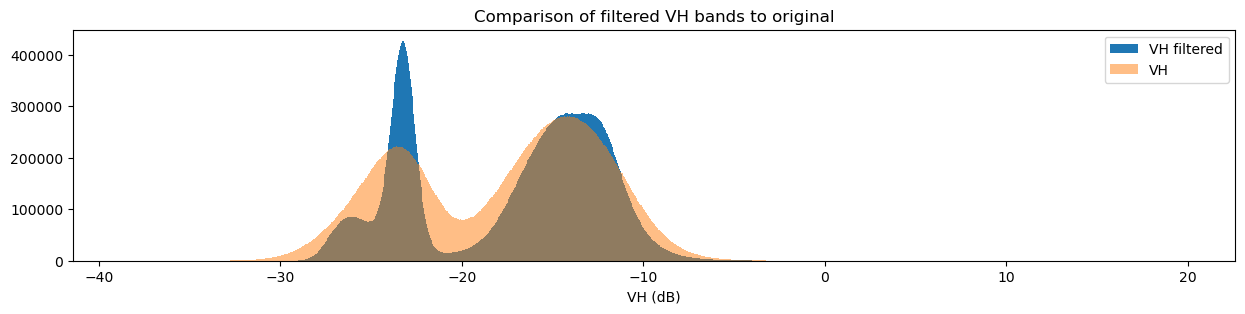

In [15]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vh_dB.plot.hist(bins=1000, label="VH filtered")
ds_s1.vh_dB.plot.hist(bins=1000, label="VH", alpha=0.5)
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Comparison of filtered VH bands to original")
plt.show()

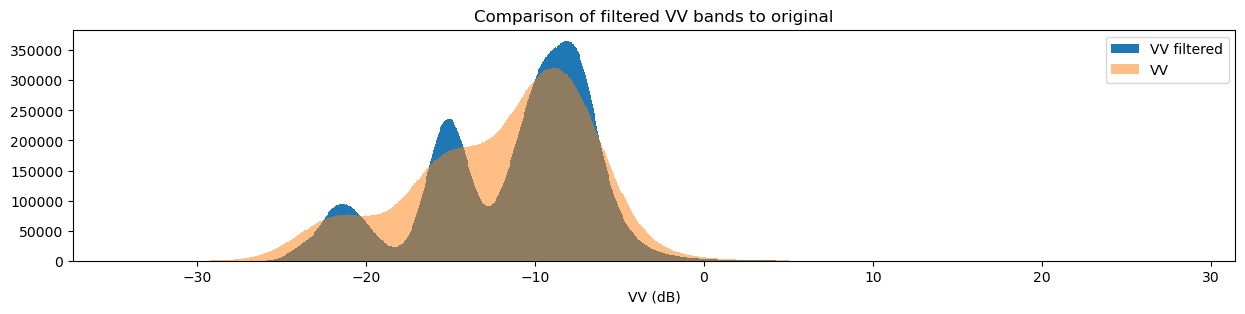

In [16]:
fig = plt.figure(figsize=(15, 3))
ds_s1.filtered_vv_dB.plot.hist(bins=1000, label="VV filtered")
ds_s1.vv_dB.plot.hist(bins=1000, label="VV", alpha=0.5)
plt.legend()
plt.xlabel("VV (dB)")
plt.title("Comparison of filtered VV bands to original")
plt.show()

In [17]:
threshold = -20.0

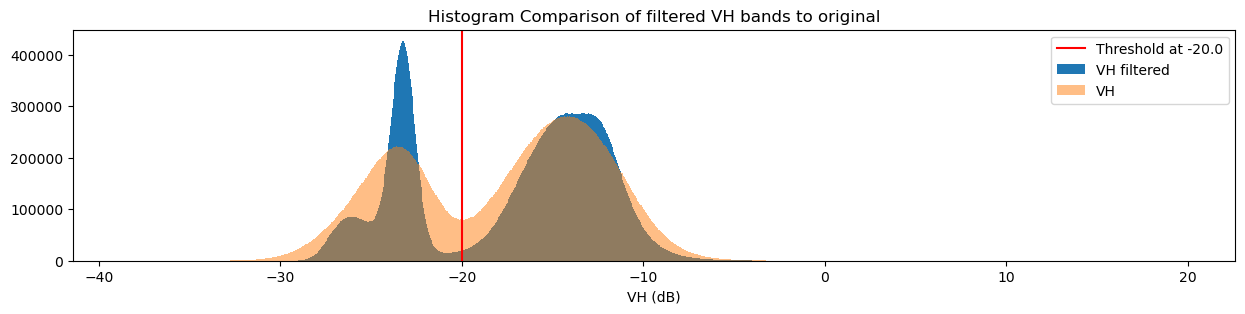

In [18]:
fig = plt.figure(figsize=(15, 3))
plt.axvline(x=threshold, label=f"Threshold at {threshold}", color="red")
ds_s1.filtered_vh_dB.plot.hist(bins=1000, label="VH filtered")
ds_s1.vh_dB.plot.hist(bins=1000, label="VH", alpha=0.5)
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Histogram Comparison of filtered VH bands to original")
plt.show()

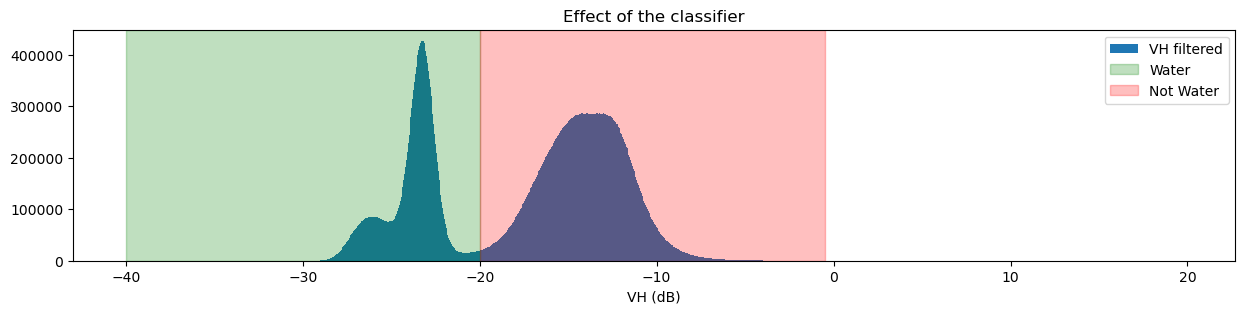

In [19]:
fig, ax = plt.subplots(figsize=(15, 3))
ds_s1.filtered_vh_dB.plot.hist(bins=1000, label="VH filtered")
ax.axvspan(xmin=-40.0, xmax=threshold, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold,
           xmax=-0.5,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

In [20]:
def s1_water_classifier(ds, threshold=-20.0):
    assert "vh" in ds.data_vars, "This classifier is expecting a variable named `vh` expressed in DN, not DB values"
    filtered = ds.vh.groupby("time").apply(lee_filter, size=7)
    water_data_array = 10 * np.log10(filtered) < threshold
    return water_data_array.to_dataset(name="s1_water")

In [21]:
ds_s1["water"] = s1_water_classifier(ds_s1).s1_water

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [22]:
print(ds_s1.water)

<xarray.DataArray 'water' (time: 3, y: 4031, x: 5765)>
array([[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True

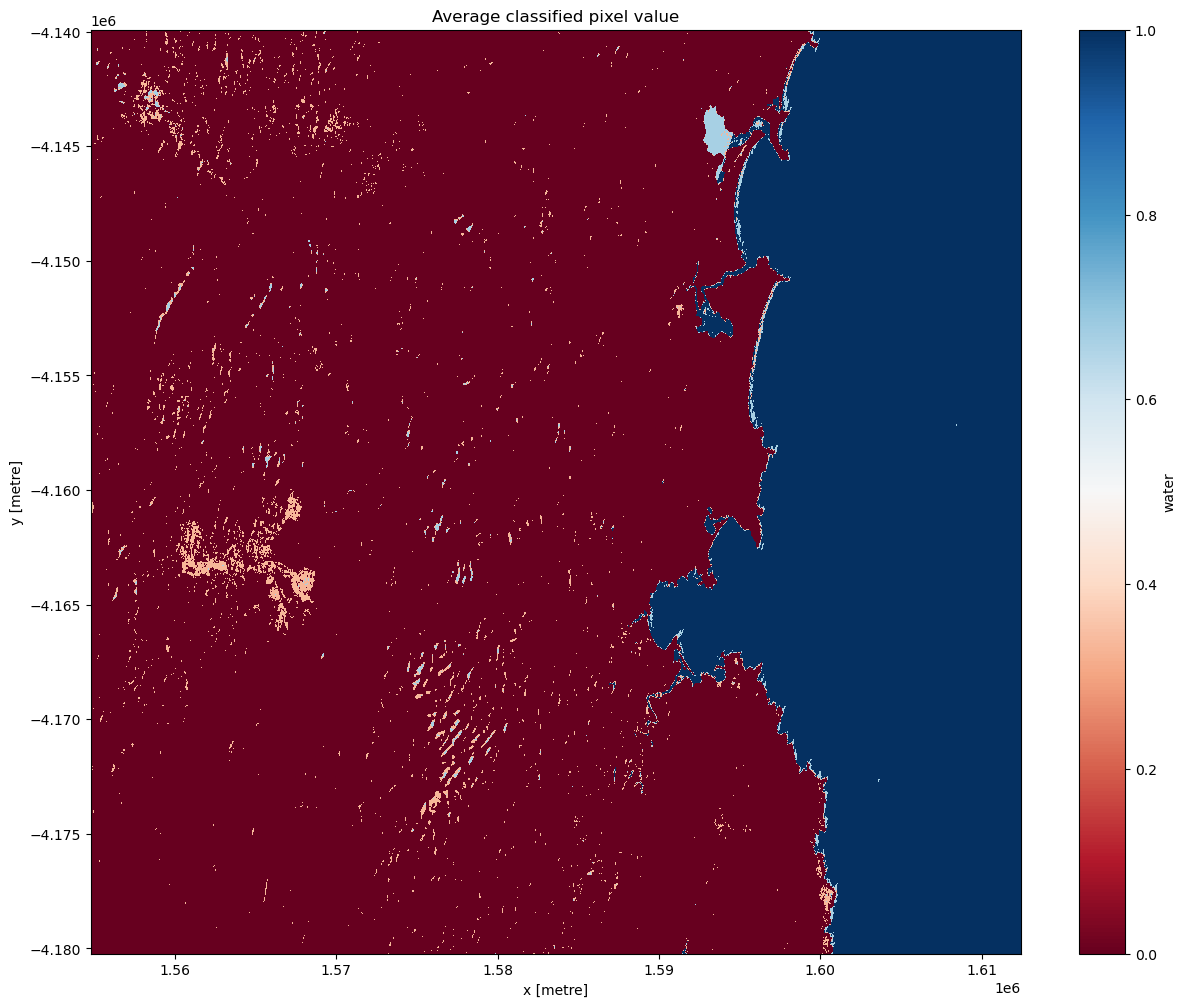

In [23]:
# Plot the mean of each classified pixel value
plt.figure(figsize=(15, 12))
ds_s1_mean = ds_s1.water.mean(dim="time")
ds_s1_mean.plot(cmap="RdBu")
plt.title("Average classified pixel value")
plt.show()

In [24]:
ds_s1_mean

<xarray.DataArray 'water' (y: 4031, x: 5765)>
array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])
Coordinates:
  * y            (y) float64 -4.14e+06 -4.14e+06 ... -4.18e+06 -4.18e+06
  * x            (x) float64 1.555e+06 1.555e+06 ... 1.612e+06 1.612e+06
    spatial_ref  int32 3577

In [25]:
# Write GeoTIFF ##### remember doesn't overwrite so need to delete if already exists #####
write_cog(geo_im=ds_s1_mean,
          fname='./data/' + site_name + '_' + starttime + '_' + endtime + '.tif',
          overwrite=True,
          # nodata=0.0
         )

PosixPath('data/eden_2020-02-07_2020-02-28.tif')

### VV

In [26]:
threshold = -12.0

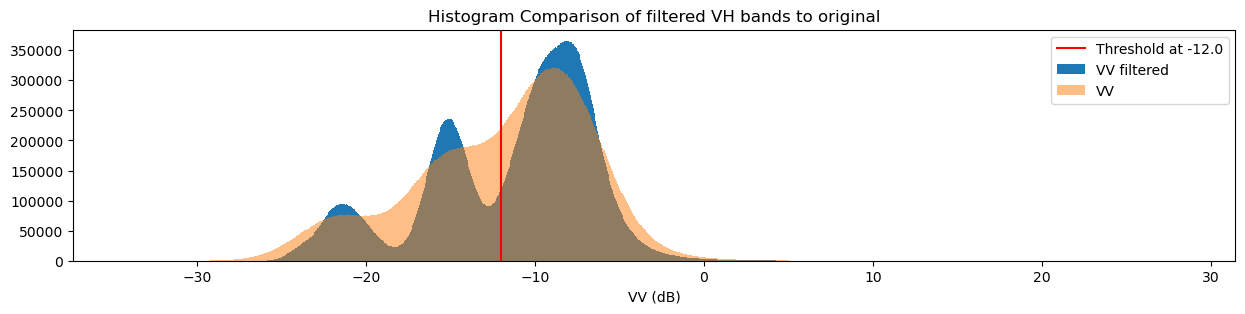

In [27]:
fig = plt.figure(figsize=(15, 3))
plt.axvline(x=threshold, label=f"Threshold at {threshold}", color="red")
ds_s1.filtered_vv_dB.plot.hist(bins=1000, label="VV filtered")
ds_s1.vv_dB.plot.hist(bins=1000, label="VV", alpha=0.5)
plt.legend()
plt.xlabel("VV (dB)")
plt.title("Histogram Comparison of filtered VH bands to original")
plt.show()

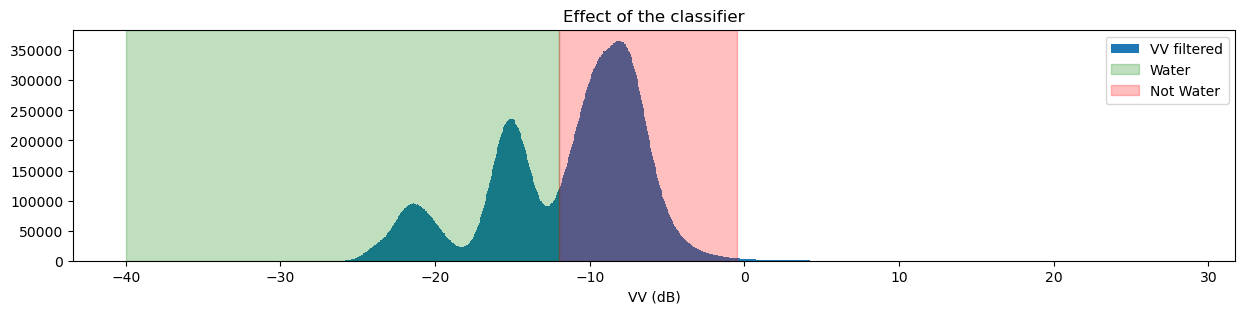

In [28]:
fig, ax = plt.subplots(figsize=(15, 3))
ds_s1.filtered_vv_dB.plot.hist(bins=1000, label="VV filtered")
ax.axvspan(xmin=-40.0, xmax=threshold, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold,
           xmax=-0.5,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlabel("VV (dB)")
plt.title("Effect of the classifier")
plt.show()

In [29]:
def s1_water_classifier(ds, threshold=-20.0):
    assert "vv" in ds.data_vars, "This classifier is expecting a variable named `vv` expressed in DN, not DB values"
    filtered = ds.vv.groupby("time").apply(lee_filter, size=7)
    water_data_array = 10 * np.log10(filtered) < threshold
    return water_data_array.to_dataset(name="s1_water")

In [30]:
ds_s1["water"] = s1_water_classifier(ds_s1).s1_water

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [31]:
print(ds_s1.water)

<xarray.DataArray 'water' (time: 3, y: 4031, x: 5765)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True,  True, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False

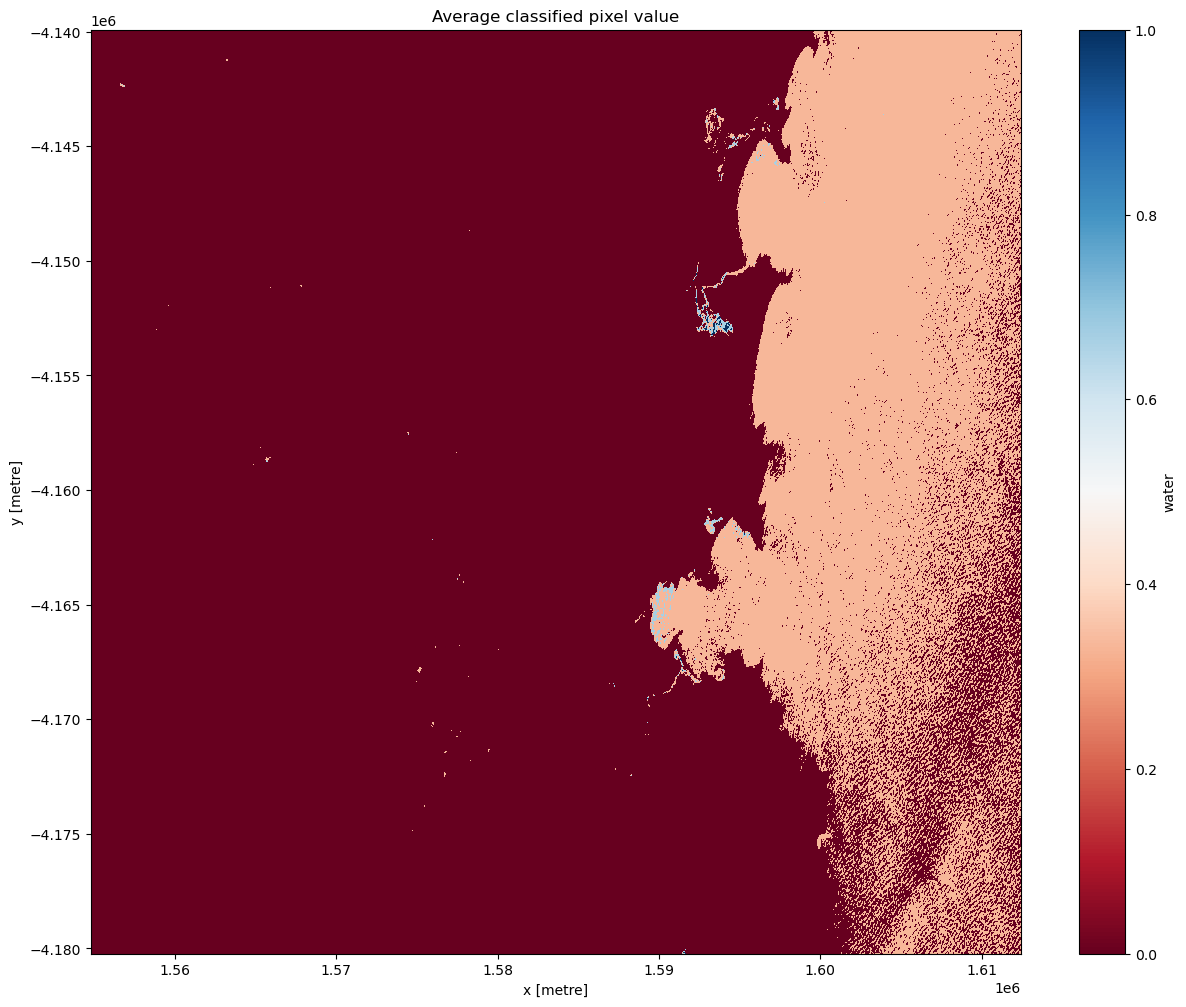

In [32]:
# Plot the mean of each classified pixel value
plt.figure(figsize=(15, 12))
ds_s1_mean = ds_s1.water.mean(dim="time")
ds_s1_mean.plot(cmap="RdBu")
plt.title("Average classified pixel value")
plt.show()